<a href="https://colab.research.google.com/github/Mathieu-van-Luijken/Transfer-Learning-for-Predictive-Process-Monitoring-/blob/main/hw3generative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import math
import torch
import torch.nn as nn
import torch.utils 
from torch.nn import Sigmoid
from torch.optim import Adam
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
#Loading in the data
dataset_path = '~/datasets'
batch_size = 100

mnist_transform = transforms.Compose([
        transforms.ToTensor(),])

kwargs = {'num_workers': 1, 'pin_memory': True} 


train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_data = torch.utils.data.Subset(train_dataset, range(0,50000))
val_data = torch.utils.data.Subset(train_dataset, range(50000, 60000))

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, **kwargs)
vali_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=True,  **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



In [7]:

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)
    
class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()
    def forward(self,x):
        return x[:, :, :28, :28]



In [8]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3,3), stride=(1, 1), padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(3, 3),  padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1),  padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.z_mean = torch.nn.Linear(8*8*64, 10)
        self.z_var =nn.Sequential(
            torch.nn.Linear(8*8*64, 10),
            torch.nn.Softplus())


        
        self.decoder = nn.Sequential(
            torch.nn.Linear(10, 8*8*64),
            Reshape(-1, 64, 8, 8),
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride = (1, 1),  padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),            
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride = (3, 3),  padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride = (1, 1),  padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 2 output channels, one for mu one for sigma
            # alternatively one for beta one for alpha
            nn.ConvTranspose2d(32, 1, kernel_size=(3, 3), stride = (1, 1), padding=0),
            # this for gauss (i guess)
            # nn.Sigmoid()
            # this for beta
            Trim(),
            nn.Softplus()
        )
    
    def reparametization(self, z_mu, z_var):
        #batch_mu_z + torch.sqrt(batch_var_z) * torch.randn(batch_var_z.shape, device=device)
        z = z_mu + torch.sqrt(z_var)*torch.randn(z_var.shape,device=device)
        #eps = torch.randn_like(torch.exp(z_log_var),device=device)
        #z = z_mu + torch.exp(z_log_var) * eps

        return z
  
    
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_var = self.z_mean(x), self.z_var(x)
        encoded = self.reparametization(z_mean, z_var)
        decoded = self.decoder(encoded)
        return decoded, z_mean, z_var

In [11]:
vae = VAE().to(device)

def loss_function(x, x_reconstr, mu, log_sigma):
    reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
    total_loss = reconstr_loss + kl_loss
    return total_loss, reconstr_loss, kl_loss

optimizer = Adam(vae.parameters(), lr=0.005)

In [10]:
vae = VAE().to(device)
# need to redefine the loss function for beta
def loss_function(x, x_reconstr, mu_z, var_z):

    #reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    d2 = (x_reconstr[:,:1,:,:]-x)**2
    #print(d2)
    var = x_reconstr[:,1:,:,:]
    e = 1e-5
    var = torch.tensor([0.5]).to(device)
    reconstr_loss = 0.5 * torch.sum(torch.log(var * 2 * np.pi) + d2 / var)          

    #distribution = torch.distributions.beta.Beta(x_reconstr[:,:1,:,:],
    #                                     x_reconstr[:,1:,:,:])
    
    #reconstr_loss = torch.sum(-distribution.log_prob(x+e*(0.5-x)))

    
    kl_loss = -0.5 * torch.sum(1-mu_z.pow(2) + torch.log(var_z) - var_z)
    total_loss = reconstr_loss + kl_loss

    return total_loss, reconstr_loss, kl_loss

optimizer = Adam(vae.parameters(), lr=0.005)

In [ ]:
vae = VAE().to(device)
# need to redefine the loss function for categorical
def loss_function(x, x_reconstr, mu_z, var_z):

    #reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    d2 = (x_reconstr[:,:1,:,:]-x)**2
    #print(d2)
    var = x_reconstr[:,1:,:,:]
    e = 1e-5
    var = torch.tensor([0.5]).to(device)
    reconstr_loss = 0.5 * torch.sum(torch.log(var * 2 * np.pi) + d2 / var)          



    
    kl_loss = -0.5 * torch.sum(1-mu_z.pow(2) + torch.log(var_z) - var_z)
    total_loss = reconstr_loss + kl_loss

    return total_loss, reconstr_loss, kl_loss

optimizer = Adam(vae.parameters(), lr=0.005)

In [ ]:
vae = VAE().to(device)
# need to redefine the loss function for bernoulli
def loss_function(x, x_reconstr, mu_z, var_z):

    #reconstr_loss = nn.functional.mse_loss(x_reconstr, x, reduction='sum')
    d2 = (x_reconstr[:,:1,:,:]-x)**2
    #print(d2)
    var = x_reconstr[:,1:,:,:]
    e = 1e-5
    var = torch.tensor([0.5]).to(device)


    reconstr_loss = 0.5 * torch.sum(torch.log(var * 2 * np.pi) + d2 / var)          

    #distribution = torch.distributions.beta.Beta(x_reconstr[:,:1,:,:],
    #                                     x_reconstr[:,1:,:,:])
    
    #reconstr_loss = torch.sum(-distribution.log_prob(x+e*(0.5-x)))

    
    kl_loss = -0.5 * torch.sum(1-mu_z.pow(2) + torch.log(var_z) - var_z)
    total_loss = reconstr_loss + kl_loss

    return total_loss, reconstr_loss, kl_loss

optimizer = Adam(vae.parameters(), lr=0.005)

In [12]:
epochs = 50

print("Start training VAE...")
start_time = time.time()
vae.train()

train_ELBO = []
validation_ELBO = []

for epoch in range(epochs):
    
    overall_loss = 0
    overall_reconstr_loss = 0
    overall_kl_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):

        optimizer.zero_grad()
        x = x.to(device)
        x_reconstr, mu, log_sigma = vae(x)
        loss, reconstr_loss, kl_loss = loss_function(x, x_reconstr, mu, log_sigma)
        overall_loss += loss.item()
        overall_reconstr_loss += reconstr_loss.item()
        overall_kl_loss += kl_loss.item()
        
        loss.backward()
        optimizer.step()
        
        
        
    n_datapoints = batch_idx * batch_size
    train_ELBO.append(overall_loss/n_datapoints)
    
    with torch.no_grad():
        validation_loss = 0
        validation_reconstr_loss = 0
        validation_kl_loss = 0
        for batch_idx, (x, y) in enumerate(vali_loader):
            x = x.to(device)
            y = y.to(device)
            x_reconstr, mu, log_sigma = vae(x)
            loss, reconstr_loss, kl_loss = loss_function(x, x_reconstr, mu, log_sigma)
            
            validation_loss += loss.item()
            validation_reconstr_loss += reconstr_loss.item()
            validation_kl_loss += kl_loss.item()
            
        n_datapoints = batch_idx * batch_size
        validation_ELBO.append(validation_loss/n_datapoints)
            
    if (np.absolute(train_ELBO[epoch] - train_ELBO[epoch-1]) <= 0.05) and (epoch != 0):
        print(train_ELBO)
        break
        
    print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / n_datapoints, "\tReconstruction Loss:", overall_reconstr_loss / n_datapoints, "\tKL Loss:", overall_kl_loss / n_datapoints)
    
print("Training complete!")
print(start_time - time.time())

Start training VAE...
	Epoch 1 	Average Loss:  744.1716989721433 	Reconstruction Loss: 431.09876704052243 	KL Loss: 313.07294382654055
	Epoch 2 	Average Loss:  147.14807131372316 	Reconstruction Loss: 128.9716838181621 	KL Loss: 18.176387407707445
	Epoch 3 	Average Loss:  125.94652111939709 	Reconstruction Loss: 109.73313037602588 	KL Loss: 16.21339040120443
	Epoch 4 	Average Loss:  113.12919531003394 	Reconstruction Loss: 98.5134339365333 	KL Loss: 14.615761282564414
	Epoch 5 	Average Loss:  104.79888856830019 	Reconstruction Loss: 91.559013634884 	KL Loss: 13.23987482090189
	Epoch 6 	Average Loss:  96.95018073804451 	Reconstruction Loss: 85.72233367611663 	KL Loss: 11.227847188313802
	Epoch 7 	Average Loss:  91.36490093809185 	Reconstruction Loss: 81.53556428543244 	KL Loss: 9.829336534750581
	Epoch 8 	Average Loss:  85.80080715603299 	Reconstruction Loss: 77.39695250848327 	KL Loss: 8.403854746192392
	Epoch 9 	Average Loss:  81.3003337081755 	Reconstruction Loss: 74.23529089725379 	

1B


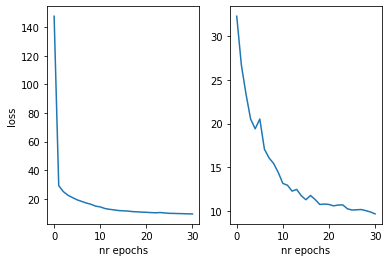

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(train_ELBO)
ax2.plot(validation_ELBO);
ax1.set_xlabel('nr epochs')
ax2.set_xlabel('nr epochs')
ax1.set_ylabel('loss');



1D: reconstructions


In [14]:
vae.eval()

x_original_list = []
y_list = []
x_reconstr_list = []
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size,1,28,28)
        x = x.to(device)
        
        x_reconstr, mu, log_sigma= vae(x)
        x_original_list.append(x)
        y_list.append(y)
        x_reconstr_list.append(x_reconstr)


100%|██████████| 100/100 [00:01<00:00, 72.51it/s]


1D: Make our own images

In [15]:
with torch.no_grad():
    noise = torch.randn(batch_size, 10).to(device)
    generated_images = vae.decoder(noise)

In [16]:
import matplotlib.pyplot as plt


def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy(), cmap="Greys_r")



In [22]:
from datetime import datetime
def show_images(x, ncols=16):
    """ plots first ncols images in a batch """
    x = x.view(batch_size, 28, 28)


    fig, ax = plt.subplots(1, ncols, figsize=(40, 2))
    for idx in range(ncols):
        ax[idx].imshow(x[idx].cpu().numpy(), cmap="Greys_r")
        ax[idx].axis('off')
    time =  datetime.now().strftime('%H%M%S')
    fig.savefig(f'figure: {time}')

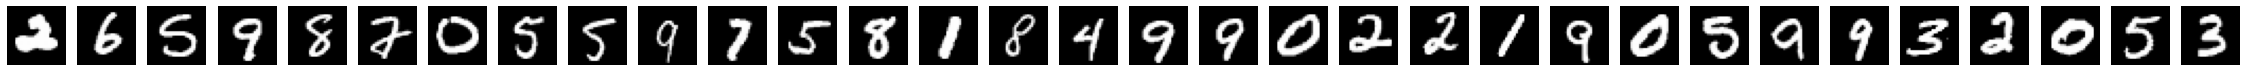

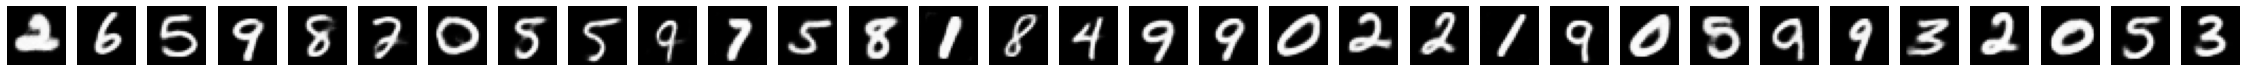

In [18]:
batch_idx = 0
show_images(x_original_list[batch_idx])
show_images(x_reconstr_list[batch_idx])

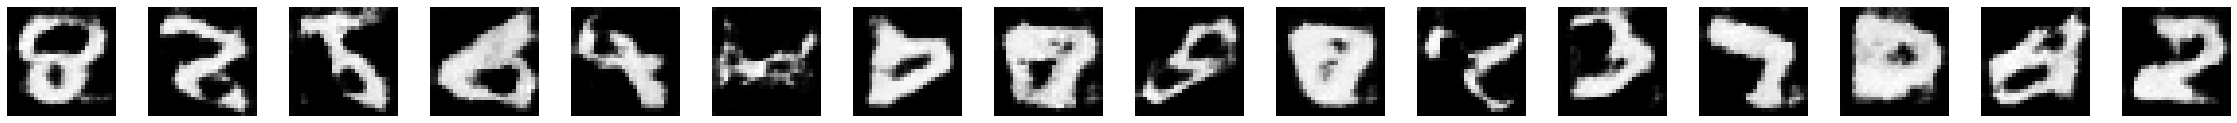

In [23]:
show_images(generated_images)

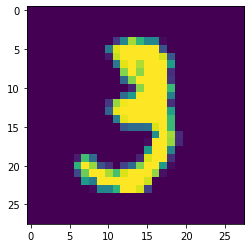

In [ ]:
u = vae(train_data[10][0].view(1,1,28,28).to(device))[0].cpu().detach().numpy()
img = u[:,0,:,:]/(u[:,0,:,:]+u[:,1,:,:])
plt.imshow(train_data[10][0].numpy()[0,:,:])


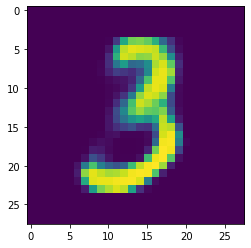

In [ ]:
plt.imshow(img[0])

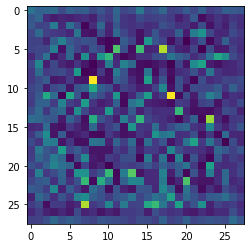

In [ ]:
plt.imshow(x_reconstr.cpu().detach().numpy()[23,0,:,:])

#3a


In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3,3), stride=(1, 1), padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(3, 3),  padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1),  padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.z_mean = torch.nn.Linear(8*8*64, 2)
        self.z_var =nn.Sequential(
            torch.nn.Linear(8*8*64, 2),
            torch.nn.Softplus())


        
        self.decoder = nn.Sequential(
            torch.nn.Linear(2, 8*8*64),
            Reshape(-1, 64, 8, 8),
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride = (1, 1),  padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),            
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride = (3, 3),  padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride = (1, 1),  padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 2 output channels, one for mu one for sigma
            # alternatively one for beta one for alpha
            nn.ConvTranspose2d(32, 2, kernel_size=(3, 3), stride = (1, 1), padding=0),
            # this for gauss (i guess)
            # nn.Sigmoid()
            # this for beta
            nn.Softplus()
        )
    
    def reparametization(self, z_mu, z_var):
        #batch_mu_z + torch.sqrt(batch_var_z) * torch.randn(batch_var_z.shape, device=device)
        z = z_mu + torch.sqrt(z_var)*torch.randn(z_var.shape,device=device)
        #eps = torch.randn_like(torch.exp(z_log_var),device=device)
        #z = z_mu + torch.exp(z_log_var) * eps

        return z
  
    
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_var = self.z_mean(x), self.z_var(x)
        encoded = self.reparametization(z_mean, z_var)
        decoded = self.decoder(encoded)
        return decoded, z_mean, z_var

In [ ]:
test_dataset = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)
test_data = torch.utils.data.Subset(test_dataset, range(0,1000))
test_loader  = DataLoader(dataset=test_data,  batch_size=batch_size, shuffle=True,  **kwargs)
vae.eval()

x_original_list = []
y_list = []
x_reconstr_list = []
z_list = []
log_sigma_list = []
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(tqdm(test_loader)):
        x = x.to(device)
        
        x_reconstr, z_mu, log_sigma = vae(x)
        x_original_list.append(x)
        y_list.append(y)
        x_reconstr_list.append(x_reconstr)
        z_list.append(z_mu)
        log_sigma_list.append(log_sigma)

In [ ]:
plt.figure(figsize=(12, 10))
for z, y in zip(z_list, y_list):
    mu = mu.cpu().numpy()
    plt.scatter(mu[:, 0], mu[:, 1], c=y)
plt.colorbar()
plt.xlabel("z_1")
plt.ylabel("z_2")
plt.show()

#3b

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3,3), stride=(1, 1), padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(3, 3),  padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1),  padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.z_mean = torch.nn.Linear(8*8*64, 10)
        self.z_var =nn.Sequential(
            torch.nn.Linear(8*8*64, 10),
            torch.nn.Softplus())


        
        self.decoder = nn.Sequential(
            torch.nn.Linear(10, 8*8*64),
            Reshape(-1, 64, 8, 8),
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride = (1, 1),  padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),            
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride = (3, 3),  padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride = (1, 1),  padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 2 output channels, one for mu one for sigma
            # alternatively one for beta one for alpha
            nn.ConvTranspose2d(32, 2, kernel_size=(3, 3), stride = (1, 1), padding=0),
            # this for gauss (i guess)
            # nn.Sigmoid()
            # this for beta
            nn.Softplus()
        )
    
    def reparametization(self, z_mu, z_var):
        #batch_mu_z + torch.sqrt(batch_var_z) * torch.randn(batch_var_z.shape, device=device)
        z = z_mu + torch.sqrt(z_var)*torch.randn(z_var.shape,device=device)
        #eps = torch.randn_like(torch.exp(z_log_var),device=device)
        #z = z_mu + torch.exp(z_log_var) * eps

        return z
  
    
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_var = self.z_mean(x), self.z_var(x)
        encoded = self.reparametization(z_mean, z_var)
        decoded = self.decoder(encoded)
        return decoded, z_mean, z_var

In [ ]:
plt.figure(figsize=(12, 10))
for z, y in zip(z_list, y_list):
    z = z.cpu().numpy()
    pca_feat = pca.fit_transform(mu)
    plt.scatter(pca_feat[:, 0], pca_feat[:, 1], c=y)
plt.colorbar()
plt.xlabel("pca_1")
plt.ylabel("pca_2")
plt.show()

#3c

#4a

In [ ]:
# from https://stackoverflow.com/questions/62429782/pytorch-how-to-implement-one-link-per-neuron
class ElementWiseLinear(nn.Module):
    __constants__ = ['n_features']
    n_features: int
    weight: torch.Tensor
    def __init__(self, n_features: int, bias: bool = True) -> None:
        super(ElementWiseLinear, self).__init__()
        self.n_features = n_features
        self.weight = nn.Parameter(torch.Tensor(1, n_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(n_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    def reset_parameters(self) -> None:
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        output = torch.mul(input, self.weight)
        if self.bias is not None:
            output += self.bias
        return output
    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.n_features, self.n_features, self.bias is not None
        )

In [ ]:
class VAE_4(nn.Module):
    def __init__(self, dims):
        super().__init__()
        # use the single link linear layers to update the original, random gaussian
        # psi_x = psi_0*elementwiselinear        
        self.z_mean = ElementWiseLinear(10, bias=False)
        self.z_var =nn.Sequential(
            ElementWiseLinear(10, bias=False),
            torch.nn.Softplus())
        
        self.decoder = nn.Sequential(
            torch.nn.Linear(10, 8*8*64),
            Reshape(-1, 64, 8, 8),
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride = (1, 1),  padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),            
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride = (3, 3),  padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride = (1, 1),  padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 2 output channels, one for mu one for sigma
            # alternatively one for beta one for alpha
            nn.ConvTranspose2d(32, 2, kernel_size=(3, 3), stride = (1, 1), padding=0),
            # this for gauss (i guess)
            # nn.Sigmoid()
            # this for beta
            nn.Softplus()
        )
    
    def reparametization(self, z_mu, z_var):

        z = z_mu + torch.sqrt(z_var)*torch.randn(z_var.shape,device=device)


        return z
  
    
    def forward(self, x, psi1, psi2):
        z_mean, z_var = self.z_mean(psi1), self.z_var(psi2)
        encoded = self.reparametization(z_mean, z_var)
        decoded = self.decoder(encoded)
        return decoded, z_mean, z_var

In [ ]:
def loss_function(x, x_reconstr, mu_z, var_z):

    d2 = (x_reconstr[:,:1,:,:]-x)**2
    e = 1e-5
    var = torch.tensor([0.5]).to(device)
    reconstr_loss = 0.5 * torch.sum(torch.log(var * 2 * np.pi) + d2 / var)          

    #distribution = torch.distributions.beta.Beta(x_reconstr[:,:1,:,:],
    #                                     x_reconstr[:,1:,:,:])
    
    #reconstr_loss = torch.sum(-distribution.log_prob(x+e*(0.5-x)))

    
    kl_loss = -0.5 * torch.sum(1-mu_z.pow(2) + torch.log(var_z) - var_z)
    total_loss = reconstr_loss + kl_loss

    return total_loss, reconstr_loss, kl_loss



In [ ]:
train_data = torch.utils.data.Subset(train_dataset, range(0,1))
train_loader = DataLoader(dataset=train_data)

In [ ]:
epochs = 20000
vae = VAE_4(dims=10).to(device)
optimizer = Adam(vae.parameters(), lr=0.0005)
print("Start training VAE...")
start_time = time.time()
vae.train()

train_ELBO = []
validation_ELBO = []
psi1, psi2 = torch.rand(10), torch.rand(10)
for epoch in range(epochs):
    
    overall_loss = 0
    overall_reconstr_loss = 0
    overall_kl_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):

        optimizer.zero_grad()
        x = x.to(device)
        x_reconstr, mu, log_sigma = vae(x, psi1, psi2)
        loss, reconstr_loss, kl_loss = loss_function(x, x_reconstr, mu, log_sigma)
        overall_loss += loss.item()
        overall_reconstr_loss += reconstr_loss.item()
        overall_kl_loss += kl_loss.item()
        
        loss.backward()
        optimizer.step()
        
        
        
    n_datapoints = batch_idx * batch_size
    train_ELBO.append((-overall_reconstr_loss + overall_kl_loss))
    
    with torch.no_grad():
        validation_loss = 0
        validation_reconstr_loss = 0
        validation_kl_loss = 0
        for batch_idx, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            x_reconstr, mu, log_sigma = vae(x, psi1, psi2)
            loss, reconstr_loss, kl_loss = loss_function(x, x_reconstr, mu, log_sigma)
            
            validation_loss += loss.item()
            validation_reconstr_loss += reconstr_loss.item()
            validation_kl_loss += kl_loss.item()
            
        n_datapoints = batch_idx * batch_size
        validation_ELBO.append((-validation_reconstr_loss + validation_kl_loss))
            
    if (np.absolute(train_ELBO[epoch] - train_ELBO[epoch-1]) <= 0.0001) and (epoch != 0):
        print(train_ELBO)
        break

    if epoch % 50 == 0:  
      print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss, "\tReconstruction Loss:", overall_reconstr_loss, "\tKL Loss:", overall_kl_loss)
    
print("Training complete!")
print(start_time - time.time())

Start training VAE...
	Epoch 1 	Average Loss:  667.8106079101562 	Reconstruction Loss: 667.4266357421875 	KL Loss: 0.3839696943759918
	Epoch 51 	Average Loss:  474.1078796386719 	Reconstruction Loss: 473.71728515625 	KL Loss: 0.3905956745147705
	Epoch 101 	Average Loss:  469.660888671875 	Reconstruction Loss: 469.2591247558594 	KL Loss: 0.4017651379108429
	Epoch 151 	Average Loss:  464.3257751464844 	Reconstruction Loss: 463.91851806640625 	KL Loss: 0.407259076833725
	Epoch 201 	Average Loss:  453.856201171875 	Reconstruction Loss: 453.4459228515625 	KL Loss: 0.4102841019630432
	Epoch 251 	Average Loss:  454.47021484375 	Reconstruction Loss: 454.059326171875 	KL Loss: 0.41089344024658203
	Epoch 301 	Average Loss:  451.55780029296875 	Reconstruction Loss: 451.1458435058594 	KL Loss: 0.41194501519203186
	Epoch 351 	Average Loss:  451.0120849609375 	Reconstruction Loss: 450.60003662109375 	KL Loss: 0.41206204891204834
	Epoch 401 	Average Loss:  450.8488464355469 	Reconstruction Loss: 450.

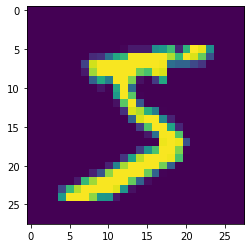

In [ ]:
plt.imshow(x[0,0])

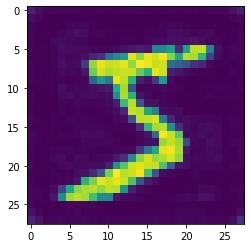

In [ ]:
img = vae(x,psi1,psi2)[0][0][0]
plt.imshow(img.detach().numpy())

#4b

In [ ]:
class VAE_4(nn.Module):
    def __init__(self, dims):
        super().__init__()        
        self.z_mean = ElementWiseLinear(10, bias=False)
        self.z_var =nn.Sequential(
            ElementWiseLinear(10, bias=False),
            torch.nn.Softplus())
        
        self.decoder = nn.Sequential(
            torch.nn.Linear(10, 8*8*64),
            Reshape(-1, 64, 8, 8),
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride = (1, 1),  padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),            
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride = (3, 3),  padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=(3, 3), stride = (1, 1),  padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 2 output channels, one for mu one for sigma
            # alternatively one for beta one for alpha
            nn.ConvTranspose2d(32, 2, kernel_size=(3, 3), stride = (1, 1), padding=0),
            # this for gauss (i guess)
            # nn.Sigmoid()
            # this for beta
            nn.Softplus()
        )
    
    def reparametization(self, z_mu, z_var):

        z = z_mu + torch.sqrt(z_var)*torch.randn(z_var.shape,device=device)


        return z
  
    
    def forward(self, x, psi1, psi2):
        z_mean, z_var = self.z_mean(psi1), self.z_var(psi2)
        encoded = self.reparametization(z_mean, z_var)
        decoded = self.decoder(encoded)
        return decoded, z_mean, z_var

In [ ]:
def loss_function(x, x_reconstr, mu_z, var_z):

    d2 = (x_reconstr[:,:1,:,:14]-x[:,:,:,:14])**2
    e = 1e-5
    var = torch.tensor([0.5]).to(device)
    reconstr_loss = 0.5 * torch.sum(torch.log(var * 2 * np.pi) + d2 / var)          

    #distribution = torch.distributions.beta.Beta(x_reconstr[:,:1,:,:],
    #                                     x_reconstr[:,1:,:,:])
    
    #reconstr_loss = torch.sum(-distribution.log_prob(x+e*(0.5-x)))

    
    kl_loss = -0.5 * torch.sum(1-mu_z.pow(2) + torch.log(var_z) - var_z)
    total_loss = reconstr_loss + kl_loss

    return total_loss, reconstr_loss, kl_loss



In [ ]:
train_data = torch.utils.data.Subset(train_dataset, range(1,2))
train_loader = DataLoader(dataset=train_data)

In [ ]:
epochs = 20000
vae = VAE_4(dims=10).to(device)
optimizer = Adam(vae.parameters(), lr=0.0005)
print("Start training VAE...")
start_time = time.time()
vae.train()

train_ELBO = []
validation_ELBO = []
psi1, psi2 = torch.rand(10).to(device), torch.rand(10).to(device)
for epoch in range(epochs):
    
    overall_loss = 0
    overall_reconstr_loss = 0
    overall_kl_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):

        optimizer.zero_grad()
        x = x.to(device)
        x_reconstr, mu, log_sigma = vae(x, psi1, psi2)
        loss, reconstr_loss, kl_loss = loss_function(x, x_reconstr, mu, log_sigma)
        overall_loss += loss.item()
        overall_reconstr_loss += reconstr_loss.item()
        overall_kl_loss += kl_loss.item()
        
        loss.backward()
        optimizer.step()
        
        
        
    n_datapoints = batch_idx * batch_size
    train_ELBO.append((-overall_reconstr_loss + overall_kl_loss))
    
    with torch.no_grad():
        validation_loss = 0
        validation_reconstr_loss = 0
        validation_kl_loss = 0
        for batch_idx, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            x_reconstr, mu, log_sigma = vae(x, psi1, psi2)
            loss, reconstr_loss, kl_loss = loss_function(x, x_reconstr, mu, log_sigma)
            
            validation_loss += loss.item()
            validation_reconstr_loss += reconstr_loss.item()
            validation_kl_loss += kl_loss.item()
            
        n_datapoints = batch_idx * batch_size
        validation_ELBO.append((-validation_reconstr_loss + validation_kl_loss))
            
    if (np.absolute(train_ELBO[epoch] - train_ELBO[epoch-1]) <= 0.0001) and (epoch != 0):
        print(train_ELBO)
        break

    if epoch % 50 == 0:  
      print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss, "\tReconstruction Loss:", overall_reconstr_loss, "\tKL Loss:", overall_kl_loss)
    
print("Training complete!")
print(start_time - time.time())

Start training VAE...
	Epoch 1 	Average Loss:  560.428466796875 	Reconstruction Loss: 560.1088256835938 	KL Loss: 0.3196175992488861
	Epoch 51 	Average Loss:  243.75442504882812 	Reconstruction Loss: 243.4320068359375 	KL Loss: 0.3224170207977295
	Epoch 101 	Average Loss:  230.9805145263672 	Reconstruction Loss: 230.65623474121094 	KL Loss: 0.32428431510925293
	Epoch 151 	Average Loss:  233.02296447753906 	Reconstruction Loss: 232.69699096679688 	KL Loss: 0.32597145438194275
	Epoch 201 	Average Loss:  229.40875244140625 	Reconstruction Loss: 229.0816192626953 	KL Loss: 0.32713866233825684
	Epoch 251 	Average Loss:  230.184814453125 	Reconstruction Loss: 229.8572235107422 	KL Loss: 0.3275870978832245
	Epoch 301 	Average Loss:  227.55770874023438 	Reconstruction Loss: 227.23037719726562 	KL Loss: 0.32733017206192017
	Epoch 351 	Average Loss:  227.39683532714844 	Reconstruction Loss: 227.0701446533203 	KL Loss: 0.32669657468795776
	Epoch 401 	Average Loss:  229.6197052001953 	Reconstructi

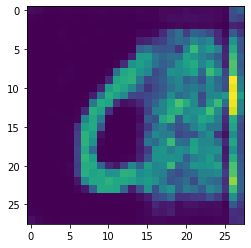

In [ ]:
img = vae(x,psi1,psi2)[0][0][0]
plt.imshow(img.cpu().detach().numpy())

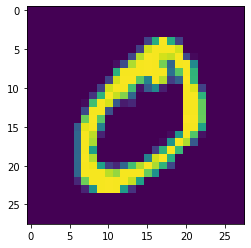

In [ ]:
plt.imshow(x[0,0,:,:].cpu())